# Algorithm: Decision Tree
Acknowledgement: Most of the code was referenced from Prof. Mafas Raheem's AML lab-5.1.
## Model Validation Strategy
Three models evaluated with two different datasets as described below (altogether 6 models).
### Standard dataset (without class balancing)
- Base
- Grid-Search-CV
- Random-Search-CV
### Oversampled dataset (with class balancing)
- Base
- Grid-Search-CV
- Random-Search-CV
### Conclusion (for all evaluations)
- accuracy chart

In [40]:
import warnings
from collections import Counter

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from imblearn.over_sampling import SMOTE
from numpy import arange
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn.tree import DecisionTreeClassifier

import custom_libs.evaluation_helper as ev
import models.uci_heart_disease_dataset as uci

# Warning was disabled to capture errors and warning. Can be enabled when needed.
warnings.filterwarnings("ignore")

In [41]:
# Load the preprocessed dataset (299 records; with 14 features)
data = pd.read_csv(uci.UCIHeartDiseaseDataFile.cleveland_preprocessed, names = uci.get_standard_features())
print(f'Data shape: {data.shape}.')
data.head(3)

Data shape: (299, 14).


,Age,Gender,Chest Pain,BP Systolic,Cholesterol,Blood Sugar,Rest ECG,Exe. Max Heartrate,Exe. Induced Angina,Exe. ST Depression,Exe. ST Segment Slope,Major Vessels,Thalassemia,Target
0,63,1,1,145,233.0,1,2,150,0,2.3,3,0,6,0
1,67,1,4,160,286.0,0,2,108,1,1.5,2,3,3,1
2,67,1,4,120,229.0,0,2,129,1,2.6,2,2,7,1


# Set Models' Hyperparameters and Cross-Validation Strategy

In [42]:
# Verbose variable for log inspection.
verbose = False

# Dictionary to hold hyperparameters for grid and random search.
parameters = dict()
# The function to measure the quality of a split. Default=gini.
parameters['criterion'] = ['entropy', 'gini', 'log_loss']
# The maximum depth of the tree. Default=None.
parameters['max_depth'] = [2, 3, 5, 10, 50]
# The number of features to consider when looking for the best split. Default=None.
parameters['max_features'] = ['log2', 'sqrt']
# The minimum number of samples required to split an internal node. Default=2.
parameters['min_samples_split'] = [2, 3, 50, 100]
# The minimum number of samples required to be at a leaf node. Default=1.
parameters['min_samples_leaf'] = [1, 5, 8, 10]

# A stratified K fold for cross-validation strategy - values are assigned from the evaluation helper module.
# When random state is enabled, shuffle has to be enabled to. Shuffle is done before the deterministic split (sklearn doc).
skfolds = StratifiedKFold(n_splits = ev.kfold_n_split,
                          shuffle = ev.kfold_shuffle,
                          random_state = ev.random_state)

# Dict for storing accuracies and drawing chart in the conclusion section.
ev.accuracies = {}

# Base Model (Function)

In [43]:
# A function to build base model.
def build_and_validate_base_model(x_train, x_test, y_train, y_test, test_name):
    print(f'\nEvaluation name: {test_name}.')

    # Train the model with training set.
    dt= DecisionTreeClassifier(random_state=ev.random_state)
    dt.fit(x_train, y_train)

    # Display the hyperparameters used.
    print(f'Params         :{ dt.get_params()}.')

    # Do prediction with the train model.
    y_pred = dt.predict(x_test)

    # Calls the evaluation helper module to display classification-report, confusion-matrix and ROC curve and return accuracy.
    return ev.display_validation_report(y_test, y_pred, x_test, dt)

# Grid Search CV (Function)

In [44]:
# A function discover the model's best hyperparameters and perform cross-validation using GridSearchCV.
def build_and_validate_with_grid_search_cv(x_train, x_test, y_train, y_test, test_name):
    print(f'\nEvaluation name: {test_name}.')

    dt= DecisionTreeClassifier(random_state=ev.random_state)

    # Build Grid-search with parameters and stratified k fold strategy for cross-validation.
    grid_scv = GridSearchCV(dt, parameters, scoring='accuracy', cv=skfolds)

    # Train and discover the model's best hyperparameters for optimal performance.
    grid_scv.fit(x_train,y_train)

    # Display the best hyperparameters and score. The best score is mean of CV scores for train-set.
    print(f'Best params         :{grid_scv.best_params_}.')
    print(f'Best score (*mean)  :{grid_scv.best_score_}.')

    # Predict using the trained model on the test-set.
    y_pred = grid_scv.predict(x_test)

    # Calls the evaluation helper module to display classification-report, confusion-matrix and ROC curve and return accuracy.
    return ev.display_validation_report(y_test, y_pred, x_test, grid_scv)

# Random Search CV (Function)

In [45]:
# A function discover the model's best hyperparameters and perform cross-validation using RandomSearchCV.
def build_and_validate_with_random_search_cv(x_train, x_test, y_train, y_test, test_name):
    print(f'\nEvaluation name: {test_name}.')

    dt= DecisionTreeClassifier(random_state=ev.random_state)

    # Build Random-search with parameters and stratified k fold strategy for cross-validation.
    rand_scv = RandomizedSearchCV(dt, parameters, scoring='accuracy', cv=skfolds)

    # Train and discover the model's best hyperparameters for optimal performance.
    rand_scv.fit(x_train,y_train)

    # Display the best hyperparameters and score. The best score is mean of CV scores for train-set.
    print(f'Best params         :{rand_scv.best_params_}.')
    print(f'Best score (*mean)  :{rand_scv.best_score_}.')

    # Predict using the trained model on the test-set.
    y_pred = rand_scv.predict(x_test)

    # Calls the evaluation helper module to display classification-report, confusion-matrix and ROC curv and return accuracy.
    return ev.display_validation_report(y_test, y_pred, x_test, rand_scv)

# Evaluation with Standard Dataset (without class balancing)

### Data Preparation

Class counter (stratified):
Entire-set  : Counter({0: 160, 1: 139}).
Train-set   : Counter({0: 128, 1: 111}).
Test-set    : Counter({0: 32, 1: 28}).


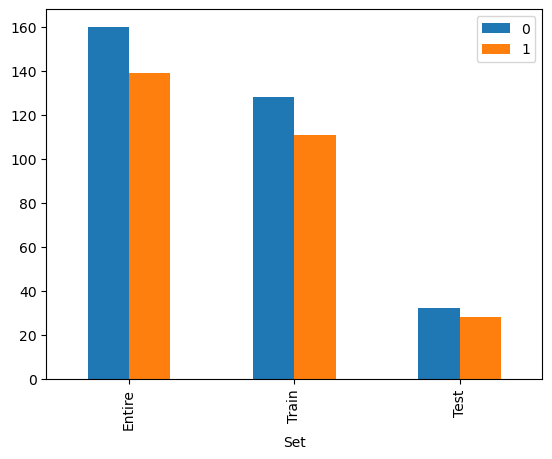

In [46]:
# Prepare features and target variables.
X = data.drop(uci.UCIHeartDiseaseData.target, axis = 1)
y = data[uci.UCIHeartDiseaseData.target]

# Calls the evaluation helper module to scale features and do split (classes are balanced using stratify split).
X_train, X_test, Y_train, Y_test = ev.scale_and_split(X, y)

# Display the counter for '1' and '0' in y set before splitting.
print('Class counter (stratified):')
print(f'Entire-set  : {Counter(y)}.')
print(f'Train-set   : {Counter(Y_train)}.')
print(f'Test-set    : {Counter(Y_test)}.')

std_y_data = [['Entire', Counter(y).get(0), Counter(y).get(1)],
              ['Train', Counter(Y_train).get(0), Counter(Y_train).get(1)],
              ['Test', Counter(Y_test).get(0), Counter(Y_test).get(1)]]

pd.DataFrame(std_y_data, columns=['Set', '0', '1']).set_index('Set').plot.bar();


Evaluation name: std-base.
Params         :{'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'monotonic_cst': None, 'random_state': 42, 'splitter': 'best'}.

Classification Report
              precision    recall  f1-score   support

           0       0.76      0.81      0.79        32
           1       0.77      0.71      0.74        28

    accuracy                           0.77        60
   macro avg       0.77      0.76      0.76        60
weighted avg       0.77      0.77      0.77        60

Actual accuracy result: 76.66666666666667.
Parsed accuracy result: 77.0.

Confusion Matrix


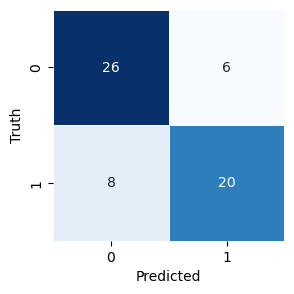

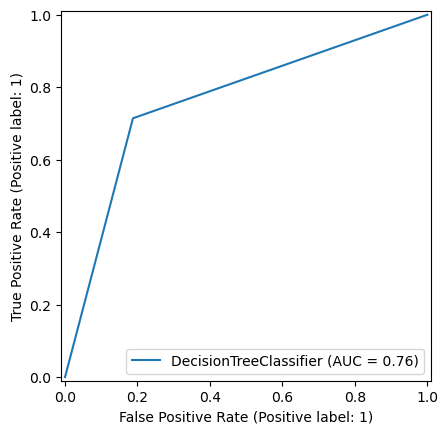

In [47]:
# Evaluation: Standard Base
acc = build_and_validate_base_model(X_train, X_test, Y_train, Y_test, ev.EvaluationType.std_base)
ev.accuracies[ev.EvaluationType.std_base] = acc


Evaluation name: std-grid-scv.
Best params         :{'criterion': 'gini', 'max_depth': 5, 'max_features': 'log2', 'min_samples_leaf': 5, 'min_samples_split': 2}.
Best score (*mean)  :0.7949468085106383.

Classification Report
              precision    recall  f1-score   support

           0       0.82      0.84      0.83        32
           1       0.81      0.79      0.80        28

    accuracy                           0.82        60
   macro avg       0.82      0.81      0.82        60
weighted avg       0.82      0.82      0.82        60

Actual accuracy result: 81.66666666666667.
Parsed accuracy result: 82.0.

Confusion Matrix


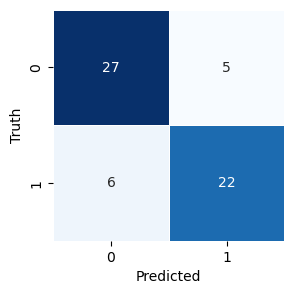

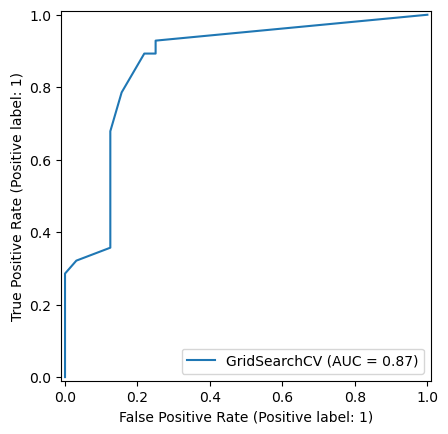

In [48]:
# Evaluation: Standard Grid Search CV
acc = build_and_validate_with_grid_search_cv(X_train, X_test, Y_train, Y_test, ev.EvaluationType.std_grid_search_cv)
ev.accuracies[ev.EvaluationType.std_grid_search_cv] = acc


Evaluation name: std-rand-scv.
Best params         :{'min_samples_split': 2, 'min_samples_leaf': 5, 'max_features': 'log2', 'max_depth': 10, 'criterion': 'entropy'}.
Best score (*mean)  :0.7699468085106382.

Classification Report
              precision    recall  f1-score   support

           0       0.83      0.94      0.88        32
           1       0.92      0.79      0.85        28

    accuracy                           0.87        60
   macro avg       0.88      0.86      0.86        60
weighted avg       0.87      0.87      0.87        60

Actual accuracy result: 86.66666666666667.
Parsed accuracy result: 87.0.

Confusion Matrix


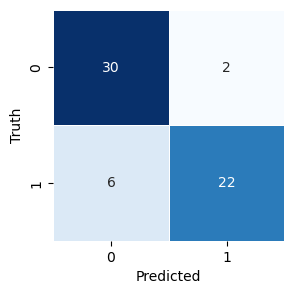

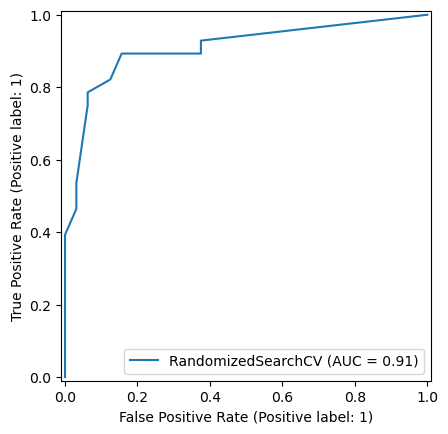

In [49]:
# Evaluation: Standard Random Search CV
acc = build_and_validate_with_random_search_cv(X_train, X_test, Y_train, Y_test, ev.EvaluationType.std_random_search_cv)
ev.accuracies[ev.EvaluationType.std_random_search_cv] = acc

In [50]:
print(f'Accuracies : {ev.accuracies}.')

Accuracies : {'std-base': 77.0, 'std-grid-scv': 82.0, 'std-rand-scv': 87.0}.


# Evaluation with Oversampled Dataset (with class balancing)

### Data Preparation and Oversampling

Class counter (stratified):
Entire-set  : Counter({0: 160, 1: 160}).
Train-set   : Counter({1: 128, 0: 128}).
Test-set    : Counter({1: 32, 0: 32}).


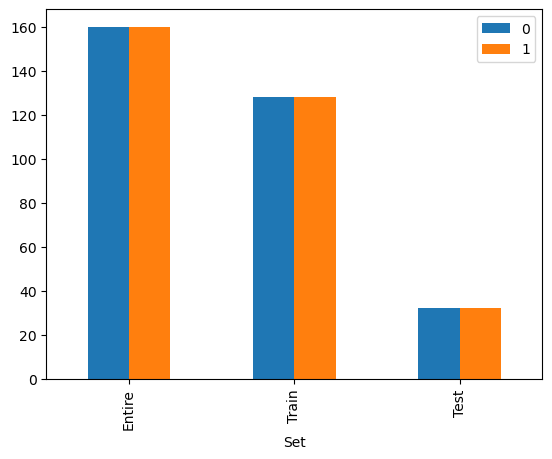

In [51]:
# Prepare features and target variables from original data frame.
X = data.drop(uci.UCIHeartDiseaseData.target, axis=1)
y = data[uci.UCIHeartDiseaseData.target]

# Perform over-sampling with SMOTE
X_b, y_b = SMOTE(random_state=ev.random_state).fit_resample(X, y)

# Scale and spit the oversampled data.
Xb_train, Xb_test, Yb_train, Yb_test = ev.scale_and_split(X_b, y_b)

# Display the counter for '1' and '0' in y set before splitting.
print('Class counter (stratified):')
print(f'Entire-set  : {Counter(y_b)}.')
print(f'Train-set   : {Counter(Yb_train)}.')
print(f'Test-set    : {Counter(Yb_test)}.')

os_y_data = [['Entire', Counter(y_b).get(0), Counter(y_b).get(1)],
              ['Train', Counter(Yb_train).get(0), Counter(Yb_train).get(1)],
              ['Test', Counter(Yb_test).get(0), Counter(Yb_test).get(1)]]

pd.DataFrame(os_y_data, columns=['Set', '0', '1']).set_index('Set').plot.bar();

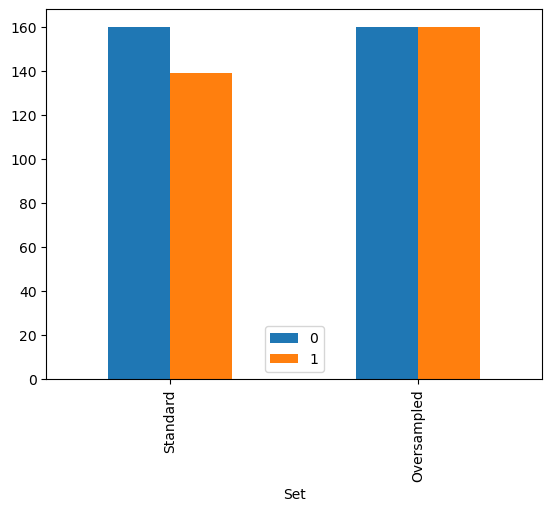

In [52]:
# Before and after oversampling
target_set_data = [['Standard', Counter(y).get(0), Counter(y).get(1)],
                   ['Oversampled', Counter(y_b).get(0), Counter(y_b).get(1)]]

pd.DataFrame(target_set_data, columns=['Set','0','1']).set_index('Set').plot.bar();


Evaluation name: os-base.
Params         :{'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'monotonic_cst': None, 'random_state': 42, 'splitter': 'best'}.

Classification Report
              precision    recall  f1-score   support

           0       0.74      0.81      0.78        32
           1       0.79      0.72      0.75        32

    accuracy                           0.77        64
   macro avg       0.77      0.77      0.77        64
weighted avg       0.77      0.77      0.77        64

Actual accuracy result: 76.5625.
Parsed accuracy result: 77.0.

Confusion Matrix


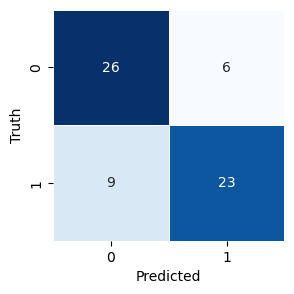

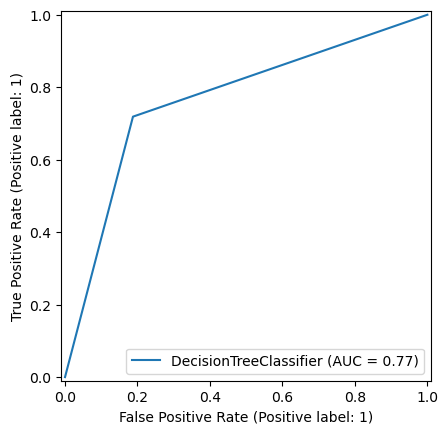

In [53]:
# Evaluation: Over-sampled Base
acc = build_and_validate_base_model(Xb_train, Xb_test, Yb_train, Yb_test, ev.EvaluationType.os_base)
ev.accuracies[ev.EvaluationType.os_base] = acc


Evaluation name: os-grid-scv.
Best params         :{'criterion': 'gini', 'max_depth': 5, 'max_features': 'log2', 'min_samples_leaf': 5, 'min_samples_split': 2}.
Best score (*mean)  :0.777450980392157.

Classification Report
              precision    recall  f1-score   support

           0       0.59      0.69      0.64        32
           1       0.63      0.53      0.58        32

    accuracy                           0.61        64
   macro avg       0.61      0.61      0.61        64
weighted avg       0.61      0.61      0.61        64

Actual accuracy result: 60.9375.
Parsed accuracy result: 61.0.

Confusion Matrix


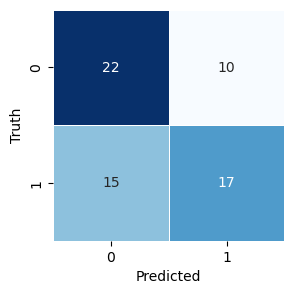

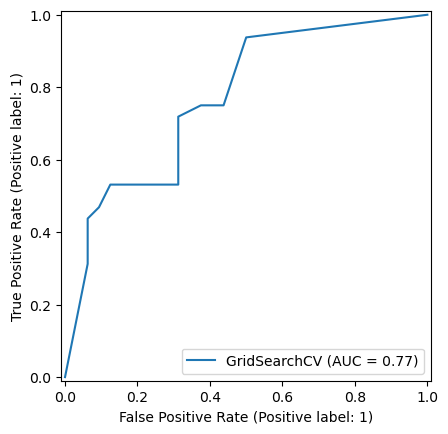

In [54]:
# Evaluation: Over-sampled Grid Search CV
acc = build_and_validate_with_grid_search_cv(Xb_train, Xb_test, Yb_train, Yb_test, ev.EvaluationType.os_grid_search_cv)
ev.accuracies[ev.EvaluationType.os_grid_search_cv] = acc


Evaluation name: os-rand-scv.
Best params         :{'min_samples_split': 3, 'min_samples_leaf': 5, 'max_features': 'log2', 'max_depth': 5, 'criterion': 'entropy'}.
Best score (*mean)  :0.7542986425339367.

Classification Report
              precision    recall  f1-score   support

           0       0.63      0.75      0.69        32
           1       0.69      0.56      0.62        32

    accuracy                           0.66        64
   macro avg       0.66      0.66      0.65        64
weighted avg       0.66      0.66      0.65        64

Actual accuracy result: 65.625.
Parsed accuracy result: 66.0.

Confusion Matrix


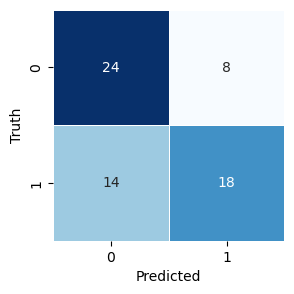

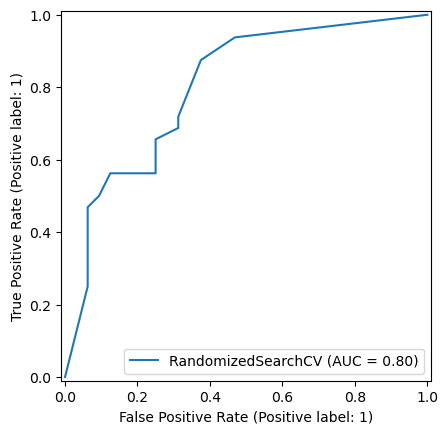

In [55]:
# Evaluation: Over-sampled Random Search CV
acc = build_and_validate_with_random_search_cv(Xb_train, Xb_test, Yb_train, Yb_test, ev.EvaluationType.os_random_search_cv)
ev.accuracies[ev.EvaluationType.os_random_search_cv] = acc

In [56]:
print(f'Accuracies : {ev.accuracies}.')

Accuracies : {'std-base': 77.0, 'std-grid-scv': 82.0, 'std-rand-scv': 87.0, 'os-base': 77.0, 'os-grid-scv': 61.0, 'os-rand-scv': 66.0}.


# Conclusion

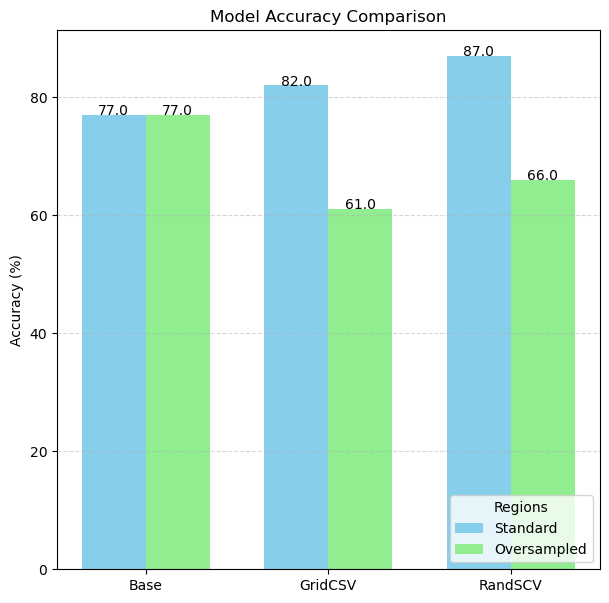

Model types             : ['Base', 'GridCSV', 'RandSCV'].
Standard accuracies     : [77.0, 82.0, 87.0].
Oversampled accuracies  : [77.0, 61.0, 66.0].
Accuracies (dict)       : {'std-base': 77.0, 'std-grid-scv': 82.0, 'std-rand-scv': 87.0, 'os-base': 77.0, 'os-grid-scv': 61.0, 'os-rand-scv': 66.0}.


In [57]:
# Function to display value on the bar chart.
def add_labels(x_pos, y_pos, delta):
    for i in range(len(x_pos)):
        dist = i + delta
        plt.text(dist, y_pos[i], y_pos[i], ha = 'center')

acc_model_type = ['Base', 'GridCSV', 'RandSCV']
bar_width = 0.35
x = np.arange(len(acc_model_type))

# Bar Plot size
plt.figure(figsize = (7,7))

# Set standard bar type and values.
acc_standard_data = [
    ev.accuracies[ev.EvaluationType.std_base],
    ev.accuracies[ev.EvaluationType.std_grid_search_cv],
    ev.accuracies[ev.EvaluationType.std_random_search_cv]
]
# Set oversampled bar type and values.
acc_oversampled_data = [
    ev.accuracies[ev.EvaluationType.os_base],
    ev.accuracies[ev.EvaluationType.os_grid_search_cv],
    ev.accuracies[ev.EvaluationType.os_random_search_cv]
]
plt.bar(x - bar_width / 2, acc_standard_data, bar_width, label='Standard', color='skyblue')
plt.bar(x + bar_width / 2, acc_oversampled_data, bar_width, label='Oversampled', color='lightgreen')

# Display value on the bar chart.
add_labels(acc_model_type,acc_standard_data,-(bar_width/2))
add_labels(acc_model_type,acc_oversampled_data, bar_width/2)

# Adding labels and title
plt.title('Model Accuracy Comparison')
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.ylabel('Accuracy (%)')
plt.xticks(x, acc_model_type)
plt.legend(title='Regions', loc='lower right')
plt.show();

# For debugging values.
print(f'Model types             : {acc_model_type}.')
print(f'Standard accuracies     : {acc_standard_data}.')
print(f'Oversampled accuracies  : {acc_oversampled_data}.')
print(f'Accuracies (dict)       : {ev.accuracies}.')

In [58]:
# Since, GridSCV perform more extensive cross-validation compared to RandSCV to ensure model's stability, the highest score between
# standard data and oversampled data for GridSCV is selected.
grid_accuracies = [ev.accuracies[ev.EvaluationType.std_grid_search_cv], ev.accuracies[ev.EvaluationType.os_grid_search_cv]]

print(f'Grid accuracies     : {grid_accuracies}.')

# Set the global score for comparisons.
ev.set_accuracy('DT', int(max(grid_accuracies)))
global_accuracies  = ev.get_accuracies()
print(f'Highest accuracy    : {global_accuracies['DT']}')
print(f'Global-result       : {global_accuracies}')

Grid accuracies     : [82.0, 61.0].
Highest accuracy    : 82
Global-result       : {'NB': 87, 'DT': 82, 'LR': 88, 'SVM': 83, 'RF': 83, 'KNN': 85, 'Latest': '2024-12-30 23:21:26'}
